<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/01_ARIMA_SARIMA_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicci√≥n y Evaluaci√≥n de los modelos Arima y Sarima

#### **Entrenamiento**

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime
from io import BytesIO

DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

In [2]:
# Mostrar informaci√≥n del subset
print("Informaci√≥n del dataset:")
print(df.info())

Informaci√≥n del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               52416 non-null  object 
 1   temperature            52416 non-null  float64
 2   humidity               52416 non-null  float64
 3   wind_speed             52416 non-null  float64
 4   general_diffuse_flows  52416 non-null  float64
 5   zone_1                 52416 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB
None


In [3]:
df_zone1 = df

Extracci√≥n de caracter√≠sticas (como la estacionariedad).

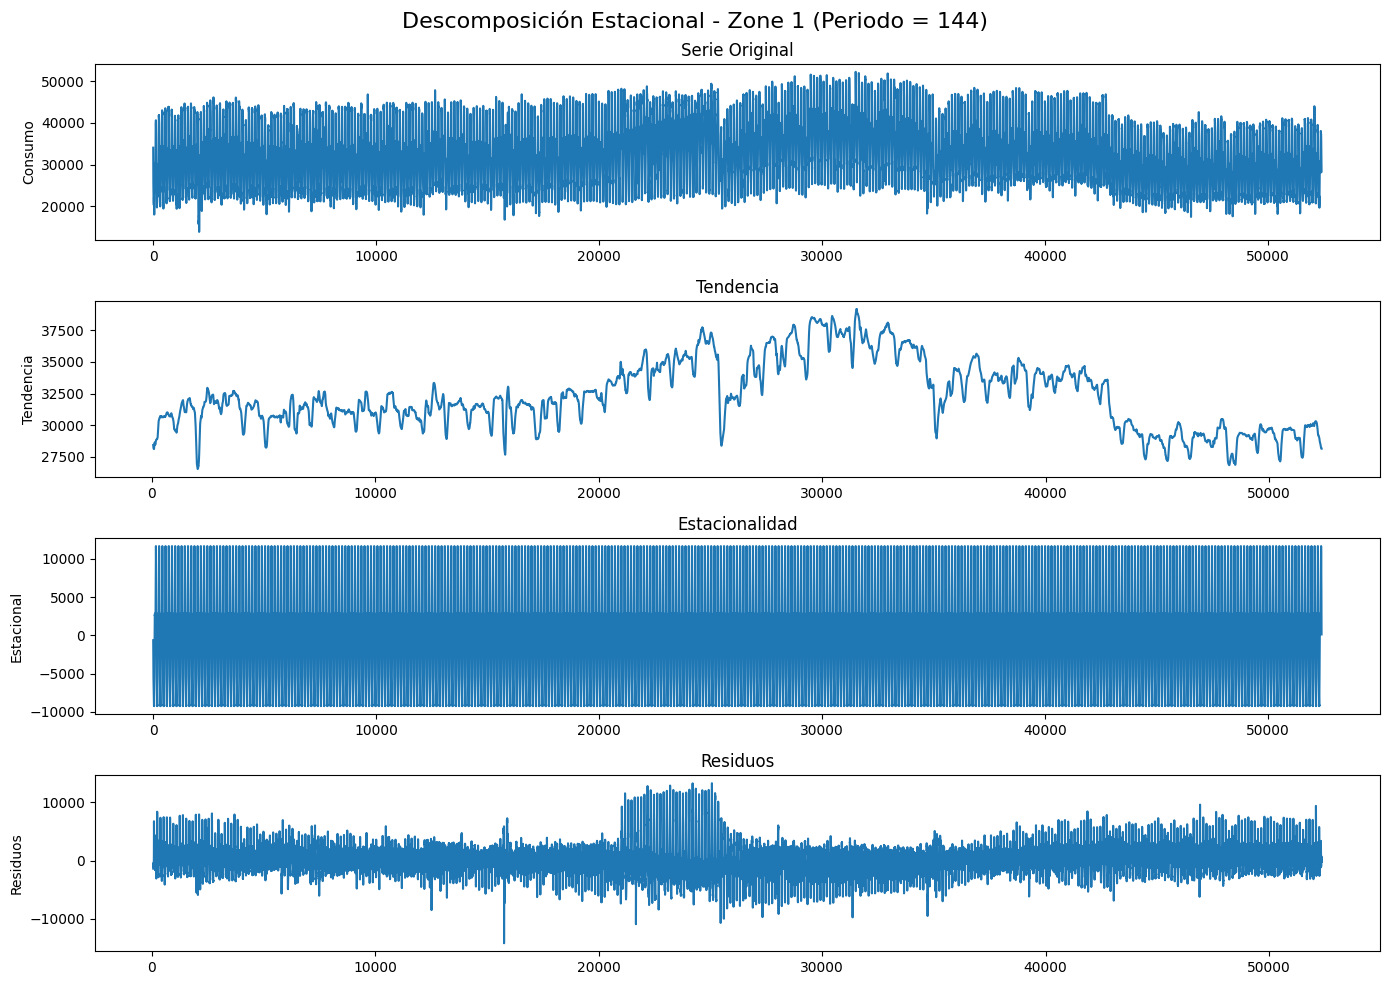

In [4]:
serie = df_zone1['zone_1']
decomposition = seasonal_decompose(serie, model='additive', period=144)

# Visualizar descomposici√≥n
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

serie.plot(ax=axes[0], title='Serie Original')
axes[0].set_ylabel('Consumo')

decomposition.trend.plot(ax=axes[1], title='Tendencia')
axes[1].set_ylabel('Tendencia')

decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
axes[2].set_ylabel('Estacional')

decomposition.resid.plot(ax=axes[3], title='Residuos')
axes[3].set_ylabel('Residuos')

plt.suptitle('Descomposici√≥n Estacional - Zone 1 (Periodo = 144)', fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print("\n=== Test de Dickey-Fuller Aumentado (Serie Original) ===")
result_adf = adfuller(serie.dropna())
print(f'ADF Statistic: {result_adf[0]:.4f}')
print(f'p-value: {result_adf[1]:.10f}')
print('Valores cr√≠ticos:')
for key, value in result_adf[4].items():
    print(f'\t{key}: {value:.3f}')


=== Test de Dickey-Fuller Aumentado (Serie Original) ===
ADF Statistic: -32.1213
p-value: 0.0000000000
Valores cr√≠ticos:
	1%: -3.430
	5%: -2.862
	10%: -2.567


### AN√ÅLISIS SOBRE LA SELECCI√ìN DE HIPERPAR√ÅMETROS

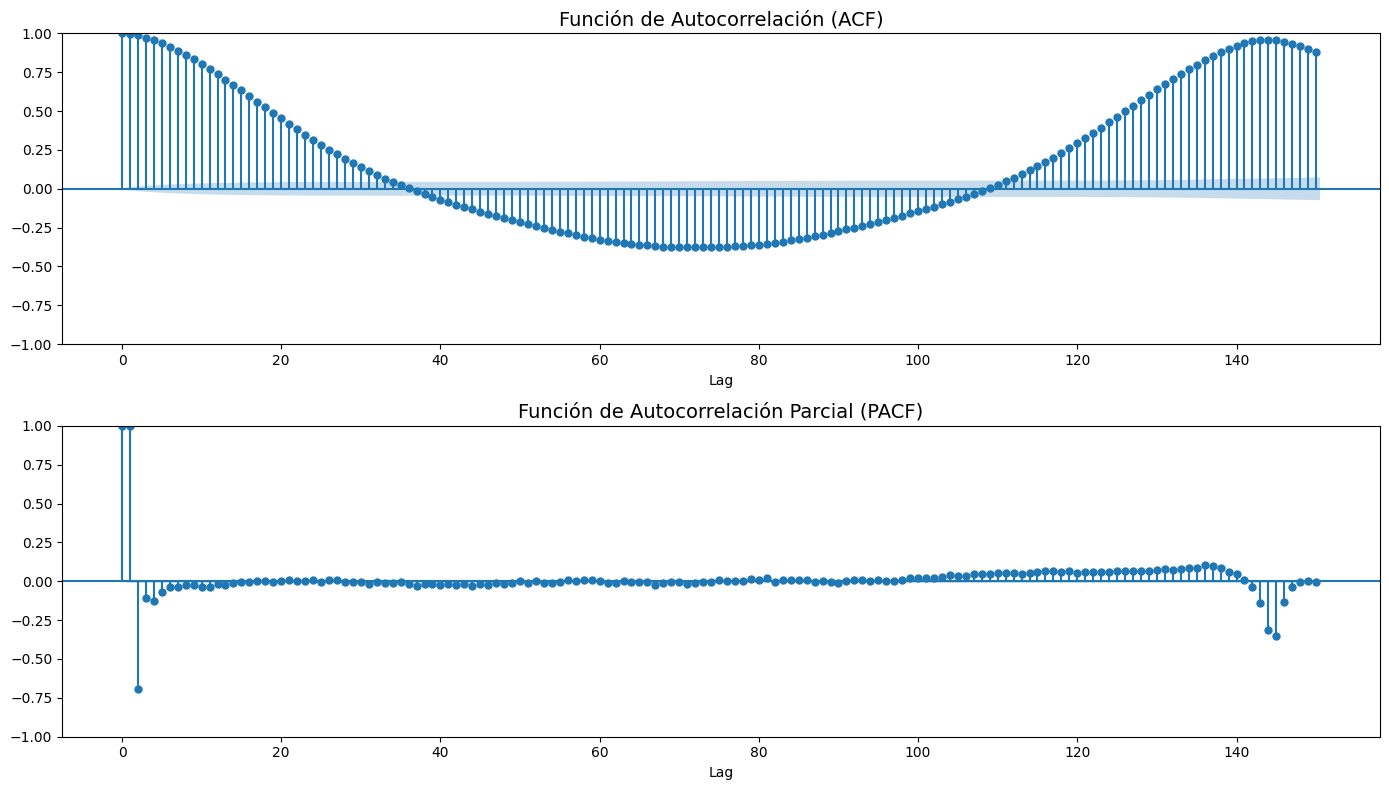

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(serie.dropna(), lags=150, ax=ax1)
ax1.set_title('Funci√≥n de Autocorrelaci√≥n (ACF)', fontsize=14)
ax1.set_xlabel('Lag')

# PACF
plot_pacf(serie.dropna(), lags=150, ax=ax2)
ax2.set_title('Funci√≥n de Autocorrelaci√≥n Parcial (PACF)', fontsize=14)
ax2.set_xlabel('Lag')

plt.tight_layout()
plt.show()

Inicialmente, se tiene que el test de Dickey-Fuller arroj√≥ un p-valor = 0.000, por lo que la serie es estacionaria y no se debe diferenciar, d = 0. La componente p de n√∫mero de t√©rminos autorregresivos se puede encontrar a partir de la gr√°fica de autocorrelaci√≥n parcial. Se pueden ver picos m√°s significativos en el lag 1 y 2, seguido de un corte abrupto. Esto indica un p = 1 o 2. La ACF no presenta un corte abrupto sino un decaimiento oscilatorio que cruza r√°pidamente las bandas de confianza, sugiriendo que q=0, aunque podr√≠a considerarse q=1 para capturar peque√±os efectos de media m√≥vil.

---

#### **Predicci√≥n**

### MODELO ARIMA

In [7]:
def smape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  return np.mean(np.abs(y_true - y_pred) / denominator) * 100

def wape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

A un paso

In [8]:
# Usar √∫ltimos 7 d√≠as
n_dias = 7
n_observaciones = n_dias * 24 * 6  # 7 d√≠as * 24h * 6 intervalos = 1008 observaciones

In [9]:
# PREDICCI√ìN A UN PASO (10 minutos adelante)

# Seleccionar datos recientes
serie_reciente = serie.tail(n_observaciones)
variable_exogena = df_zone1['temperature'].tail(n_observaciones)

# Divisi√≥n train/test (80/20)
split_point = int(len(serie_reciente) * 0.8)
train_serie = serie_reciente[:split_point]
test_serie = serie_reciente[split_point:]
train_exog = variable_exogena[:split_point].to_frame()
test_exog  = variable_exogena[split_point:].to_frame()

print("=== CONFIGURACI√ìN PARA PREDICCI√ìN A UN PASO (10 minutos) ===")
print(f"Total observaciones: {len(serie_reciente)}")
print(f"Train: {len(train_serie)} observaciones ({len(train_serie)/6:.1f} horas)")
print(f"Test: {len(test_serie)} observaciones ({len(test_serie)/6:.1f} horas)")
print(f"Horizonte de predicci√≥n: 1 paso (10 minutos)")


=== CONFIGURACI√ìN PARA PREDICCI√ìN A UN PASO (10 minutos) ===
Total observaciones: 1008
Train: 806 observaciones (134.3 horas)
Test: 202 observaciones (33.7 horas)
Horizonte de predicci√≥n: 1 paso (10 minutos)


In [10]:
import time
start_time = time.time()

p, d, q = 2, 0, 0
print(f"\n=== ENTRENANDO MODELO ARIMA({p},{d},{q}) ===")

modelo_arima = ARIMA(train_serie, order=(p, d, q))
resultado_arima = modelo_arima.fit()

print(f"AIC: {resultado_arima.aic:.2f}")
print(f"BIC: {resultado_arima.bic:.2f}")

train_time_arima = time.time() - start_time
print(f"Tiempo de entrenamiento: {train_time_arima:.2f} segundos")



=== ENTRENANDO MODELO ARIMA(2,0,0) ===
AIC: 11801.44
BIC: 11820.21
Tiempo de entrenamiento: 0.30 segundos


In [11]:
print("\n=== ARIMA - PRON√ìSTICO A UN PASO (One-step ahead) ===")

# get_prediction = usa valores reales para cada paso
pred_arima_one_step = resultado_arima.get_prediction(
    start=test_serie.index[0],
    end=test_serie.index[-1],
    dynamic=False
)

pred_arima_one_step_mean = pred_arima_one_step.predicted_mean

# Evaluamos sobre todo el test
smape_arima_1step = smape(test_serie, pred_arima_one_step_mean)
wape_arima_1step  = wape(test_serie, pred_arima_one_step_mean)

print(f"sMAPE: {smape_arima_1step:.2f}%")
print(f"WAPE : {wape_arima_1step:.2f}%")


=== ARIMA - PRON√ìSTICO A UN PASO (One-step ahead) ===
sMAPE: 17.26%
WAPE : 16.82%


A m√∫ltiples pasos

In [12]:
print("\n=== ARIMA - PRON√ìSTICO MULTI-STEP ===")

n_pasos_futuro = 18   # 3 horas adelante
pred_arima_multi = resultado_arima.get_forecast(steps=n_pasos_futuro)

pred_arima_multi_mean = pred_arima_multi.predicted_mean
pred_arima_multi_mean.index = test_serie.index[:n_pasos_futuro]

smape_arima_multi = smape(test_serie.iloc[:n_pasos_futuro], pred_arima_multi_mean)
wape_arima_multi  = wape(test_serie.iloc[:n_pasos_futuro], pred_arima_multi_mean)

print(f"sMAPE (3h): {smape_arima_multi:.2f}%")
print(f"WAPE  (3h): {wape_arima_multi:.2f}%")


=== ARIMA - PRON√ìSTICO MULTI-STEP ===
sMAPE (3h): 1.09%
WAPE  (3h): 1.09%


---

### MODELO SARIMAX


La serie temporal presenta una estacionalidad diaria extremadamente marcada, evidenciada por el comportamiento casi sinusoidal de la ACF con un pico dominante cerca del lag 144 (equivalente a 24 horas con mediciones cada 10 minutos), sugiriendo la presencia de una ra√≠z unitaria estacional que requiere diferenciaci√≥n estacional (D=1). La PACF revela un spike significativo en los lags iniciales y m√∫ltiples picos negativos alrededor del lag 144, patr√≥n caracter√≠stico que indica que, tras aplicar la diferenciaci√≥n estacional, un t√©rmino de media m√≥vil estacional captura eficientemente la dependencia temporal, siendo Q=1 la mejor elecci√≥n. Considerando que el modelo base ya incorpora order=(2,0,0), la configuraci√≥n estacional √≥ptima ser√≠a seasonal_order=(0,1,1,144) como punto de partida, dado que es la parametrizaci√≥n m√°s habitual cuando la ACF estacional domina el comportamiento de la serie.

In [13]:
# Par√°metros SARIMAX con estacionalidad diaria
order = (2, 0, 0)
seasonal_order = (0, 1, 1, 144)  # 144 = 24 horas * 6 intervalos

In [14]:
print(f"\n=== MODELO SARIMAX  ===")

start_time = time.time()
try:
    modelo_sarimax = SARIMAX(
        train_serie,
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultado_sarimax = modelo_sarimax.fit(disp=False)

    train_time_sarimax = time.time() - start_time
    print(f"Tiempo de entrenamiento: {train_time_sarimax:.2f} segundos")

except Exception as e:
    print(f"Error en el entrenamiento SARIMAX: {e}")



=== MODELO SARIMAX  ===
Tiempo de entrenamiento: 1097.35 segundos


In [22]:
print("\n=== SARIMAX - PREDICCI√ìN A UN PASO (One-step ahead) ===")

pred_sarimax_1 = resultado_sarimax.get_prediction(
    start=len(train_serie),
    end=len(train_serie) + len(test_serie) - 1,
    exog=test_exog,
    dynamic=False
)

pred_sarimax_1_mean = pred_sarimax_1.predicted_mean

smape_sarimax_1 = smape(test_serie, pred_sarimax_1_mean)
wape_sarimax_1  = wape(test_serie, pred_sarimax_1_mean)

print(f"sMAPE: {smape_sarimax_1:.2f}%")
print(f"WAPE : {wape_sarimax_1:.2f}%")


=== SARIMAX - PREDICCI√ìN A UN PASO (One-step ahead) ===
sMAPE: 3.85%
WAPE : 3.99%


In [23]:
print("\n=== SARIMAX - PRON√ìSTICO MULTI-STEP (3h adelante) ===")

pred_sarimax_multi = resultado_sarimax.get_forecast(
    steps=n_pasos_futuro,
    exog=test_exog.iloc[:n_pasos_futuro]
)

pred_sarimax_multi_mean = pred_sarimax_multi.predicted_mean
pred_sarimax_multi_mean.index = test_serie.index[:n_pasos_futuro]

smape_sarimax_multi = smape(test_serie.iloc[:n_pasos_futuro], pred_sarimax_multi_mean)
wape_sarimax_multi  = wape(test_serie.iloc[:n_pasos_futuro], pred_sarimax_multi_mean)

print(f"sMAPE (3h): {smape_sarimax_multi:.2f}%")
print(f"WAPE  (3h): {wape_sarimax_multi:.2f}%")


=== SARIMAX - PRON√ìSTICO MULTI-STEP (3h adelante) ===
sMAPE (3h): 1.41%
WAPE  (3h): 1.44%


#### **Analisis de resultados**

### PRON√ìSTICO A UN PASO MODELOS ARIMA Y SARIMAX

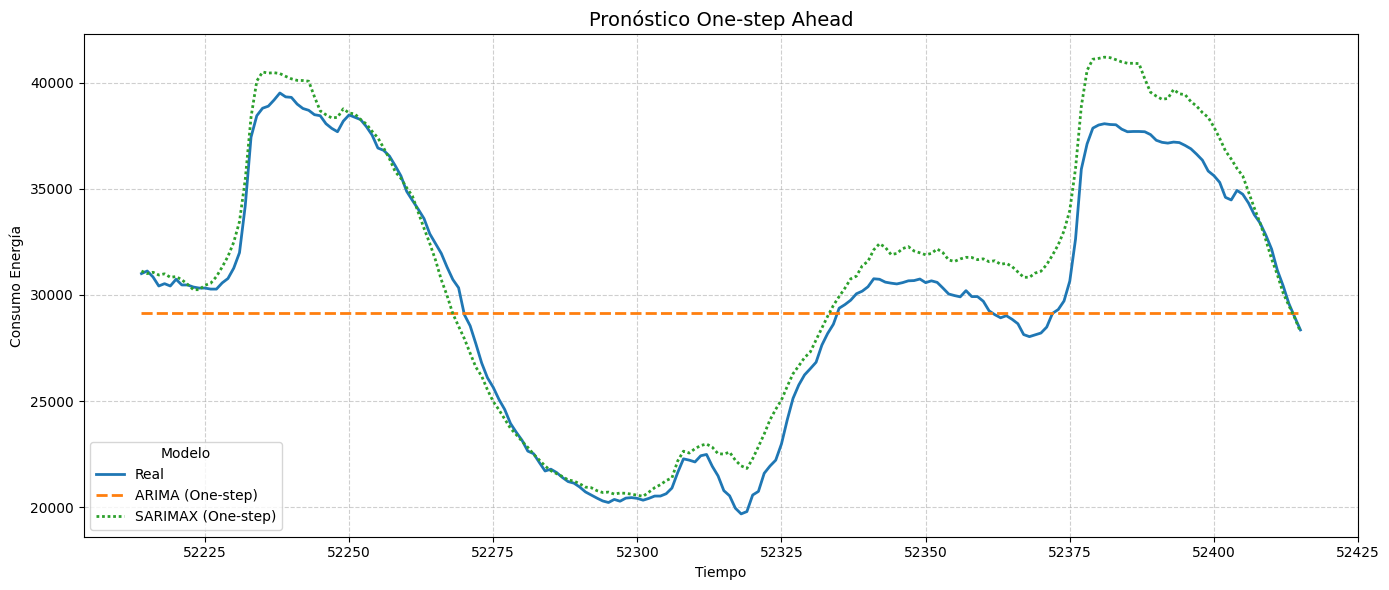

In [28]:
# Armar dataframe con predicciones one-step
df_one_step = pd.DataFrame({
    "time": test_serie.index,
    "Real": test_serie.values,
    "ARIMA (One-step)": pred_arima_one_step_mean.values,
    "SARIMAX (One-step)": pred_sarimax_1_mean.values
})

# Convertir a formato largo (tidy)
df_one_step_long = df_one_step.melt(id_vars="time",
                                    value_vars=["Real", "ARIMA (One-step)", "SARIMAX (One-step)"],
                                    var_name="Modelo", value_name="Consumo")

# Gr√°fico con seaborn
plt.figure(figsize=(14,6))
sns.lineplot(data=df_one_step_long, x="time", y="Consumo", hue="Modelo", style="Modelo", linewidth=2)

plt.title("Pron√≥stico One-step Ahead", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energ√≠a")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

En la gr√°fica del pron√≥stico One-step Ahead se observa un contraste marcado entre los dos modelos. El ARIMA, representado por la l√≠nea naranja, se mantiene pr√°cticamente constante alrededor de un valor promedio en torno a 29,000, lo cual refleja su incapacidad para capturar la fuerte estacionalidad diaria y las variaciones r√°pidas del consumo energ√©tico. En este contexto funciona apenas como un modelo base o de referencia En cambio, el SARIMAX, mostrado en verde, logra seguir de manera mucho m√°s realista la serie original: reproduce las subidas bruscas en horas de mayor demanda, as√≠ como las ca√≠das nocturnas, aunque en algunos puntos tienda a sobreestimar los picos o subestimar ciertos valles. Esto demuestra que, en un escenario con mediciones de alta frecuencia y fuerte patr√≥n estacional, un modelo ARIMA puro resulta insuficiente, mientras que SARIMAX, al incorporar diferenciaci√≥n estacional y variables ex√≥genas (como la temperatura), ofrece un ajuste considerablemente m√°s preciso y ajustado a la din√°mica real del consumo el√©ctrico.



### PRON√ìSTICO A M√öLTIPLES PASOS MODELOS ARIMA Y SARIMAX

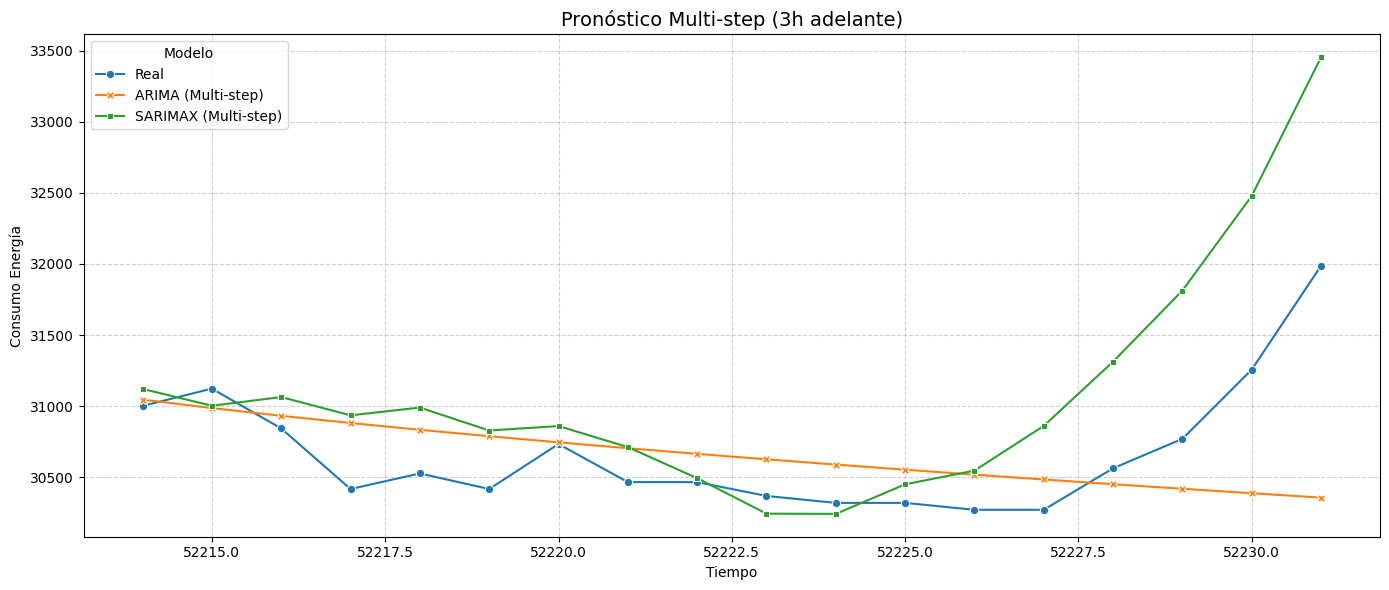

In [29]:
# Armar dataframe con predicciones multi-step
df_multi = pd.DataFrame({
    "time": test_serie.index[:n_pasos_futuro],
    "Real": test_serie.iloc[:n_pasos_futuro].values,
    "ARIMA (Multi-step)": pred_arima_multi_mean.values,
    "SARIMAX (Multi-step)": pred_sarimax_multi_mean.values
})

df_multi_long = df_multi.melt(id_vars="time",
                              value_vars=["Real", "ARIMA (Multi-step)", "SARIMAX (Multi-step)"],
                              var_name="Modelo", value_name="Consumo")

# Gr√°fico con seaborn
plt.figure(figsize=(14,6))
sns.lineplot(data=df_multi_long, x="time", y="Consumo", hue="Modelo", style="Modelo", markers=True, dashes=False)

plt.title("Pron√≥stico Multi-step (3h adelante)", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energ√≠a")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

En la predicci√≥n multi-step a 3 horas, se observa que al inicio de las predicciones SARIMAX sigue m√°s de cerca el valor real en comparaci√≥n con ARIMA, logrando captar mejor las fluctuaciones iniciales y reproduciendo con mayor realismo la trayectoria corta, mientras que ARIMA se mantiene excesivamente plano con una ligera tendencia descendente. En la parte media, cuando la serie real se sit√∫a en un nivel m√°s bajo, SARIMAX coincide con el m√≠nimo de la serie y contin√∫a mostrando mayor ajuste, mientras que ARIMA conserva su tendencia lineal. Sin embargo, en los √∫ltimos pasos del horizonte, cuando la serie real comienza a repuntar, ARIMA termina subestimando los valores al no reconocer el cambio de tendencia, mientras que SARIMAX incurre en una sobrestimaci√≥n notable, generando un crecimiento explosivo no observado en los datos reales. En conjunto, esto indica que SARIMAX ofrece mejor desempe√±o en horizontes cortos, capturando con mayor fidelidad los patrones inmediatos, aunque con riesgo de inestabilidad en horizontes m√°s largos; en contraste, ARIMA es m√°s estable y predecible en el largo plazo, pero menos sensible a cambios en la serie, lo cual lo hace conservador y plano frente a variaciones din√°micas.

TODO: An√°lisis de la gr√°fica

M√©tricas a evaluar:
1. sMAPE
2. WAPE

In [30]:
# =====================================================
# TABLA 1: Pron√≥stico One-step Ahead
# =====================================================
resultados_1paso = []

# ARIMA - one-step
if pred_arima_one_step is not None:
    resultados_1paso.append({
        "Modelo": "ARIMA (One-step)",
        "Horizonte": "1 paso (10 min)",
        "sMAPE (%)": round(smape_arima_1step, 2),
        "WAPE (%)": round(wape_arima_1step, 2),
        "AIC": round(resultado_arima.aic, 2),
        "BIC": round(resultado_arima.bic, 2)
    })

# SARIMAX - one-step
if pred_sarimax_1 is not None:
    resultados_1paso.append({
        "Modelo": "SARIMAX (One-step)",
        "Horizonte": "1 paso (10 min)",
        "sMAPE (%)": round(smape_sarimax_1, 2),
        "WAPE (%)": round(wape_sarimax_1, 2),
        "AIC": round(resultado_sarimax.aic, 2),
        "BIC": round(resultado_sarimax.bic, 2)
    })

df_resultados_1paso = pd.DataFrame(resultados_1paso)
print("\nResultados Pron√≥stico One-step Ahead:")
print(df_resultados_1paso.to_string(index=False))


# =====================================================
# TABLA 2: Pron√≥stico Multi-step (3h adelante = 18 pasos)
# =====================================================
resultados_multi = []

# ARIMA - multi-step
if pred_arima_multi is not None:
    resultados_multi.append({
        "Modelo": "ARIMA (Multi-step)",
        "Horizonte": "3h adelante (18 pasos)",
        "sMAPE (%)": round(smape_arima_multi, 2),
        "WAPE (%)": round(wape_arima_multi, 2),
        "AIC": round(resultado_arima.aic, 2),
        "BIC": round(resultado_arima.bic, 2)
    })

# SARIMAX - multi-step
if pred_sarimax_multi is not None:
    resultados_multi.append({
        "Modelo": "SARIMAX (Multi-step)",
        "Horizonte": "3h adelante (18 pasos)",
        "sMAPE (%)": round(smape_sarimax_multi, 2),
        "WAPE (%)": round(wape_sarimax_multi, 2),
        "AIC": round(resultado_sarimax.aic, 2),
        "BIC": round(resultado_sarimax.bic, 2)
    })


df_resultados_multi = pd.DataFrame(resultados_multi)
print("\nResultados Pron√≥stico Multi-step (3h adelante):")
print(df_resultados_multi.to_string(index=False))


Resultados Pron√≥stico One-step Ahead:
            Modelo       Horizonte  sMAPE (%)  WAPE (%)      AIC      BIC
  ARIMA (One-step) 1 paso (10 min)      17.26     16.82 11801.44 11820.21
SARIMAX (One-step) 1 paso (10 min)       3.85      3.99  7351.02  7372.26

Resultados Pron√≥stico Multi-step (3h adelante):
              Modelo              Horizonte  sMAPE (%)  WAPE (%)      AIC      BIC
  ARIMA (Multi-step) 3h adelante (18 pasos)       1.09      1.09 11801.44 11820.21
SARIMAX (Multi-step) 3h adelante (18 pasos)       1.41      1.44  7351.02  7372.26


---

En el an√°lisis comparativo de los modelos aplicados al pron√≥stico de consumo energ√©tico, se observa que el SARIMAX supera ampliamente al ARIMA en predicciones inmediatas (one-step ahead), obteniendo un sMAPE de 3.85% y un WAPE de 3.99%, frente a los 17.26% y 16.82% de ARIMA, lo que demuestra que la combinaci√≥n de estacionalidad expl√≠cita y variable ex√≥gena (temperatura) permite capturar de manera mucho m√°s fiel la din√°mica de la demanda. Sin embargo, en el horizonte corto de predicci√≥n multi-step (3 horas adelante), ambos modelos presentan errores bajos, con un sMAPE de 1.09% para ARIMA y 1.41% para SARIMAX, siendo en este caso sorprendentemente m√°s preciso ARIMA al suavizar mejor los valores de corto plazo, mientras que SARIMAX tiende a sobreajustar algunas oscilaciones. Respecto a los criterios de informaci√≥n, SARIMAX presenta AIC y BIC (7351 y 7372) muy inferiores a los de ARIMA (11801 y 11820), lo que indica un ajuste estad√≠sticamente m√°s s√≥lido del modelo estacional con ex√≥genas. No obstante, esta superioridad en capacidad predictiva y explicaci√≥n de la serie implica un costo computacional considerable, ya que SARIMAX requiri√≥ alrededor de 1097 segundos (aproximadamente 18 minutos) de entrenamiento en Colab, mientras que ARIMA se entren√≥ en apenas 0.3 segundos. En conjunto, esto refleja un claro trade-off entre precisi√≥n y complejidad, donde SARIMAX es la mejor opci√≥n para aplicaciones donde la exactitud en la predicci√≥n es cr√≠tica (por ejemplo, planificaci√≥n operativa de energ√≠a en tiempo real), mientras que ARIMA puede ser √∫til como modelo base ligero en escenarios que requieran reentrenamientos r√°pidos y frecuentes.

### REFERENCIAS:

Gianpiero Andrenacci. (2024, September 3). Predicting Time-Series with SARIMAX. Medium; AI Bistrot. https://medium.com/data-bistrot/predicting-time-series-with-sarimax-f805f6608cd2

‚Äågianpieroandrenacci. (2024, July 13). üìà COVID-19 New Cases in Italy prediction (ARIMA). Kaggle.com; Kaggle. https://www.kaggle.com/code/gianpieroandrenacci/covid-19-new-cases-in-italy-prediction-arima?source=post_page-----f805f6608cd2---------------------------------------

‚Äå